# The program calculates the optimum location of the network of measurement sites for determining the spatial mean value of the measured environmental parameter in the study area. The calculation is performed using a genetic algorithm on the basis of a time series of spatial data stored in a NetCDF file.

In [1]:
import numpy as np
from netCDF4 import Dataset
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import random
import math
import requests

In [2]:
num_measurement_stations = 6 # Define the number of measurement stations
# Genetic algorithm parameters
population_size = 100 
num_generations = 200 
mutation_rate = 0.1
file_name=r'x_ss_sst_merge-sb1k_avg_month.nc'
try:
    nc=Dataset(file_name,'r') 
except:                          # if the netCDF file is not in the current directory, it is downloaded from the repository
    url=r'https://mostwiedzy.pl/pl/open-research-data/monthly-mean-sea-surface-temperature-sst-of-the-baltic-sea,830062554854123-0/download'
    data = requests.get(url).content   # download data from the repository
    nc=Dataset(file_name, memory=data)

var=nc.variables['SST']  
time_steps=var.shape[0]
#Calculation of the average value for the entire area at each time step
avg=np.empty(time_steps, dtype=float)
for t in range(time_steps):
    avg[t]=var[t].mean()
data=np.moveaxis(var, 0, -1)    
# Define the search space boundaries
extent_min =(0, 0)
extent_max = (var.shape[1]-1,var.shape[2]-1)



In [3]:
def cost_function(stations): # Define the cost function to be minimized 
    #Initialization
    y = avg
    regr = linear_model.LinearRegression()
    x=np.empty((time_steps,len(stations)),float)
    for station_nr in range(len(stations)):
        x[:,station_nr]=data[stations[station_nr][0],stations[station_nr][1]]
    regr.fit(x, y)           # Make a match with sklearn
    y_pred = regr.predict(x) # Make predictions using the testing set
    MSE=mean_squared_error(y, y_pred)   #Calculate match stats
    return MSE,regr

# Initialize a random population of measurement stations
def initialize_population(population_size):
    population = []
    for _ in range(population_size):
        position=[]
        while len(position)<num_measurement_stations:
            pos=list(np.random.randint(extent_min,extent_max,2))
            if data[tuple(pos)].min()!=var.missing_value:
                position.append(pos)
        population.append(position)       
    return population

# Select individuals based on their fitness using tournament selection
def tournament_selection(population, fitness_values, tournament_size=3):
    tournament_indices = random.sample(range(len(population)), tournament_size)
    selected_index = min(tournament_indices, key=lambda i: fitness_values[i])
    return population[selected_index]

# Apply single-point crossover to create offspring
def crossover(parent1, parent2):
    crossover_point = random.randint(1, num_measurement_stations - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

# Apply mutation to an individual
def mutate(individual):
    for i in range(num_measurement_stations):        
        if random.uniform(0, 1) < mutation_rate:
            while True:
                pos=list(np.random.randint(extent_min,extent_max,2))
                if data[tuple(pos)].min()!=var.missing_value:
                    individual[i]=pos
                    break
    return individual

# Run the genetic algorithm calculations

In [4]:

population = initialize_population(population_size)

for generation in range(num_generations):
    fitness_values = [cost_function(individual)[0] for individual in population]

    new_population = []
    for _ in range(population_size // 2):
        parent1 = tournament_selection(population, fitness_values)
        parent2 = tournament_selection(population, fitness_values)
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1)
        child2 = mutate(child2)
        new_population.extend([child1, child2])

    best_fitness = min(fitness_values)
    best_individual = population[fitness_values.index(best_fitness)]
    print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")
    new_population.append(best_individual)
    population = new_population

cost,best_coef=cost_function(best_individual)
print("Optimal location of measurement stations: ", best_individual)
print(f"RMSE: {np.sqrt(cost):.4f}, intercept: {best_coef.intercept_:.4f}")
print("Regression coefficients:",best_coef.coef_)

Generation 1: Best Fitness = 0.01723013647973699
Generation 2: Best Fitness = 0.01723013647973699
Generation 3: Best Fitness = 0.01723013647973699
Generation 4: Best Fitness = 0.015119317576308685
Generation 5: Best Fitness = 0.015119317576308685
Generation 6: Best Fitness = 0.014279702199540015
Generation 7: Best Fitness = 0.014279702199540015
Generation 8: Best Fitness = 0.013794850450305023
Generation 9: Best Fitness = 0.013650020009401685
Generation 10: Best Fitness = 0.0123408781272888
Generation 11: Best Fitness = 0.01205612066965131
Generation 12: Best Fitness = 0.01175739521595479
Generation 13: Best Fitness = 0.01175739521595479
Generation 14: Best Fitness = 0.011658572413650007
Generation 15: Best Fitness = 0.010975996415814208
Generation 16: Best Fitness = 0.010975996415814208
Generation 17: Best Fitness = 0.010975996415814208
Generation 18: Best Fitness = 0.010975996415814208
Generation 19: Best Fitness = 0.010975996415814208
Generation 20: Best Fitness = 0.0104604423853629

Generation 163: Best Fitness = 0.006651132743309136
Generation 164: Best Fitness = 0.006651132743309136
Generation 165: Best Fitness = 0.006651132743309136
Generation 166: Best Fitness = 0.006651132743309136
Generation 167: Best Fitness = 0.006651132743309136
Generation 168: Best Fitness = 0.006651132743309136
Generation 169: Best Fitness = 0.006651132743309136
Generation 170: Best Fitness = 0.006651132743309136
Generation 171: Best Fitness = 0.006651132743309136
Generation 172: Best Fitness = 0.006651132743309136
Generation 173: Best Fitness = 0.006651132743309136
Generation 174: Best Fitness = 0.006651132743309136
Generation 175: Best Fitness = 0.006651132743309136
Generation 176: Best Fitness = 0.006651132743309136
Generation 177: Best Fitness = 0.006651132743309136
Generation 178: Best Fitness = 0.006651132743309136
Generation 179: Best Fitness = 0.006651132743309136
Generation 180: Best Fitness = 0.006651132743309136
Generation 181: Best Fitness = 0.006651132743309136
Generation 1

# Display the optimal measurement network on the map

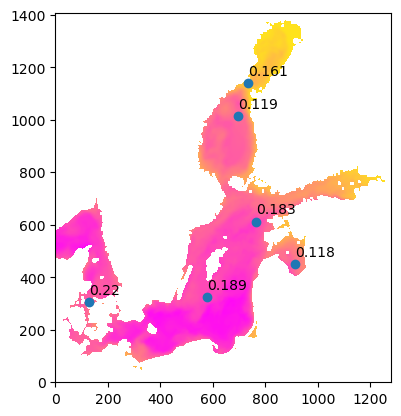

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
var_r=np.moveaxis(var[0], 0, -1)
plt.imshow(var_r, cmap='spring_r')
np_gbp=np.array(best_individual)
fig =plt.scatter(np_gbp[:,0],np_gbp[:,1])
plt.ylim( 0, var_r.shape[0])
for i in range(len(best_coef.coef_)):
    plt.annotate(round(best_coef.coef_[i],3), (np_gbp[i,0],np_gbp[i,1]+ 30))

In [6]:
import statsmodels.api as sm
y = avg
x=np.empty((time_steps,len(best_individual)),float)
for station_nr in range(len(best_individual)):
    x[:,station_nr]=data[best_individual[station_nr][0],best_individual[station_nr][1]]
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(f"RMSE\tR^2\tR^2_adj")
print(f"{np.sqrt(cost):.4f}\t{results.rsquared:.4f}\t{results.rsquared_adj:.4f}")
print(f"lambda\tfi\t{results.params[0]:.4f}\t{results.bse[0]:.4f}")
for i in range(len(best_individual)):
    pos=best_individual[i][1],best_individual[i][0]
    print(f"{float(nc.variables['Longitude'][pos]):.4f}\t{float(nc.variables['Latitude'][pos]):.4f}\t"
        f"{results.params[i+1]:.4f}\t{results.bse[i+1]:.4f} ")

RMSE	R^2	R^2_adj
0.0816	0.9998	0.9998
lambda	fi	0.1901	0.0240
20.0686	62.5465	0.1188	0.0087 
21.2404	58.9192	0.1827	0.0114 
23.6878	57.4247	0.1178	0.0083 
18.1504	56.3114	0.1892	0.0093 
10.9468	55.8331	0.2197	0.0058 
20.8157	63.6902	0.1607	0.0056 


# Print summary

In [7]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.106e+05
Date:                Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                        07:56:28   Log-Likelihood:                 287.11
No. Observations:                 264   AIC:                            -560.2
Df Residuals:                     257   BIC:                            -535.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1901      0.024      7.933      0.000       0.143       0.237
x1             0.1188      0.009     13.705      0.000       0.102       0.136
x2             0.1827      0.011     15.961      0.000       0.160       0.205
x3             0.1178      0.008     14.196      0.000       0.101       0.134
x4             0.1892      0.009     20.411      0.000       0.171       0.207
x5             0.2197      0.006     38.104      0.000       0.208       0.231
x6             0.1607      0.006     28.602      0.000       0.150       0.172
==============================================================================
Omnibus:                        3.273   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                3.577
Skew:                          -0.081   Prob(JB):                        0.167
Kurtosis:                       3.547   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
nc.close()